# Notebook: V1:
### About:
This is the `version 1` of the dataloader that I modified, but it uses the preprocessed, data and annotation .txt files for training. But in later versions I changed the data loader such that it only take images and generates the annotations by itself.

- The data preperation code, formats the data according to the model. It only changes the shape(square), does template matching and saves the bbox output of that to its respective annotation .txt file.

- I uses the existing dataloader, with slight modifications, metioned in the assigned pdf[crop, random paste]. So, caching, augmentaions are enebled as well.

- The template image used for template matching can be changed via argparse, `--template` flag. 

- The code for this is provided in the `CustomLoadImagesAndLabels` class at `utils/custom_dataloaders.py` file.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from utils.custom_dataloaders import create_dataloader
from utils.custom_dataloaders import CustomLoadImagesAndLabels

### Data Preperation:

- create `/labels/` `../img_and_labels/`
- below code `format_data` takes the train and val images folders and create its annotation .txt files and saves them to its respective folders.

In [2]:
def format_data(img_files, folder):
    for fn in tqdm(img_files): 
        main_image = cv2.imread(fn)
        template = cv2.imread('../1_3_crop.tif')


        main_gray = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)


        template_width, template_height = template_gray.shape[::-1]


        result = cv2.matchTemplate(main_gray, template_gray, cv2.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)


        top_left = max_loc
        bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

        center_x = (bottom_right[0] + top_left[0]) // 2
        center_y = (bottom_right[1] + top_left[1]) // 2


        h = bottom_right[1] - top_left[1]
        w = bottom_right[0] - top_left[0]
        
        row = np.array([[0.0, center_x/640, center_y/640, w/640, h/640]])

        row = row.astype(str)

        max_size = max(main_image.shape[0], main_image.shape[1])
        dump_img = cv2.resize(main_image, (max_size, max_size))
        
        cv2.imwrite("../img_and_labels/images/"+ folder + fn.split("/")[-1], dump_img)

        label_fn = fn.split("/")[-1].split(".")[0]
        with open('../img_and_labels/labels/'+ folder +label_fn+".txt", 'w+') as f:
            for j in range(len(row)):
                text = ' '.join(row[j])
                f.write(text)
        
def get_img_cropped(center_x, center_y, width, height, img):         
    x1 = int(center_x - width // 2)
    y1 = int(center_y - height // 2)
    
    x2 = int(x1 + width)
    y2 = int(y1 + height)

    cropped_image = img[y1:y2, x1:x2]
    return cropped_image


# create bbox txt files from template matching
train_img_files = glob.glob("../images/train/*.tif")
val_img_files = glob.glob("../images/val/*.tif")

format_data(train_img_files, "train/")
format_data(val_img_files, "val/")

  0%|          | 0/701 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 72.55it/s]


### Data Visualization

In [4]:
dataset = CustomLoadImagesAndLabels("../img_and_labels/images/train/",img_size=640,batch_size=2,rect=True)
custom_data = dataset[3]
print(custom_data)

Scanning ../img_and_labels/labels/train...:   0%|          | 0/701 [00:00<?, ?it/s]

Scanning ../img_and_labels/labels/train... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<00:00, 3985.65it/s]
New cache created: ../img_and_labels/labels/train.cache


(tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8), tensor([[0.00000, 0.00000, 0.24219, 0.21406, 0.15625, 0.15625],
        [0.00000, 0.0

(105, 87) (205, 187)
(151, 249) (251, 349)


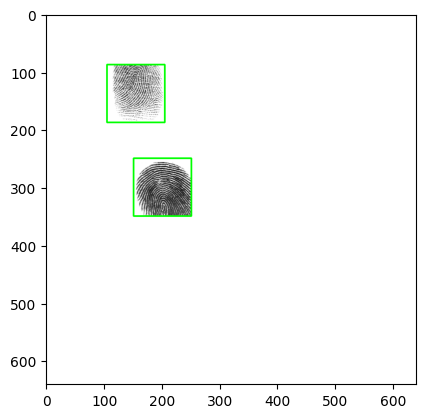

In [5]:
img_viz = custom_data[0].permute(1,2,0).numpy().astype(np.uint8).copy()
for i in range(custom_data[1].shape[0]):
    center_x, center_y, width, height  = custom_data[1][:,2:][i].numpy()*640

    x1 = int(center_x - width / 2)
    y1 = int(center_y - height / 2)

    x2 = int(center_x + width / 2)
    y2 = int(center_y + height / 2)

    color = (0, 255, 0)  
    thickness = 2  

    print((x1, y1), (x2, y2))

    cv2.rectangle(img_viz, (x1, y1), (x2, y2), color, thickness)

    plt.imshow(img_viz)


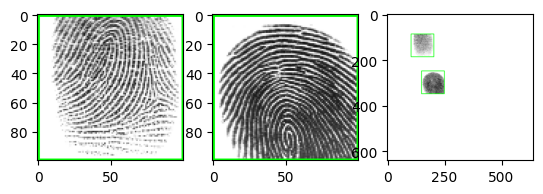

In [6]:
center_x1, center_y1, width1, height1  = custom_data[1][:,2:][0].numpy()*640
center_x2, center_y2, width2, height2  = custom_data[1][:,2:][1].numpy()*640


image1 =get_img_cropped(center_x1, center_y1, width1, height1 , img_viz)
image2 =get_img_cropped(center_x2, center_y2, width2, height2 , img_viz)


plt.subplot(1,3,1)
plt.imshow(image1)

plt.subplot(1,3,2)
plt.imshow(image2)

plt.subplot(1,3,3)
plt.imshow(img_viz)

### Training Instruction for dataloader that uses pre-processed annotation files:
- from the `train.py` file use `create_dataloader` from `utils/custom_dataloaders.py` by importing like this `from utils.custom_dataloaders import create_dataloader`.

In [7]:
IMG_SIZE = 640
BATCH_SIZE = 2
EPOCHS = 3

In [ ]:
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data ../img_and_labels/fingerprint_label.yaml \
                 --weights yolov5s.pt \
                 --project custom-dataloader

train: weights=yolov5s.pt, cfg=, data=../img_and_labels/fingerprint_label.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=2, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=custom-dataloader, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2023-8-8 Python-3.9.10 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0